In [1]:
import os
import multiprocessing
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
#     multiprocessing.cpu_count())

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import numpy as onp
import jax.random as jrandom
from functools import partial
from collections import namedtuple
from jax.random import PRNGKey
from jax import partial
import itertools
flatten = itertools.chain.from_iterable
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import Video
from mpl_toolkits.mplot3d import axes3d
import importlib
from tqdm import tqdm
from jax.lax import scan
from jax import jit
#enable double precision
# from jax.config import config
# config.update("jax_enable_x64", True)

In [3]:
sns.set_context('notebook')
plt.rcParams['font.family'] = 'VictorMono Nerd Font'
plt.rcParams['mathtext.rm'] = 'VictorMono Nerd Font ExtraLight'
plt.rcParams['mathtext.it'] = 'VictorMono Nerd Font ExtraLight Italic'
plt.rcParams['mathtext.bf'] = 'VictorMono Nerd Font Light'
plt.rcParams['mathtext.default'] = 'rm'
# plt.rcParams['mathtext.fontset'] = 'stix'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In this notebook we demonstrate a simulation of one dimensional Fokker-Plank dynamics and Zakai nonlinear filtering dynamics.

In [4]:
!pwd

/home/muhammad/GitHub/AutomaticParticleFilter/Examples/For signalprocessing paper


In [5]:
%cd ..
%cd ..

/home/muhammad/GitHub/AutomaticParticleFilter/Examples
/home/muhammad/GitHub/AutomaticParticleFilter


In [6]:
import projection_filter.n_d_exponential_family_projection_filter as pf
import numerical_pde_nonlinear_filtering.two_d_nonlinear_filter_via_pde_time_independent as two_d
import symbolic.one_d
import symbolic.n_d as n_d
from sde import SDESolverTypes, sde_solver
from sde.wiener import multidimensional_wiener_process
import other_filter.particlefilter as par_f

In [7]:
importlib.reload(two_d)

<module 'numerical_pde_nonlinear_filtering.two_d_nonlinear_filter_via_pde_time_independent' from '/home/muhammad/GitHub/AutomaticParticleFilter/numerical_pde_nonlinear_filtering/two_d_nonlinear_filter_via_pde_time_independent.py'>

In [8]:
MU= 0.3 # DEFAULT 0.6
SIGMA_W = 1e-0
SIGMA_V = 1e-0

def F(x, t):
    return jnp.array([x[1], 
                      MU * (1. - x[0] * x[0]) * x[1] - x[0], 
                      x[0]])  # Default


def G(x, t):
    return jnp.array([[0., 0.], 
                      [SIGMA_W, 0.], 
                      [0., SIGMA_V]])

x, dw, dv = sp.symbols(('x1:3', 'dw1:3', 'dv1:3'))
t = sp.symbols('t')

f = sp.Matrix([x[1], MU * (1. - x[0] * x[0]) * x[1] - x[0]])
g = sp.Matrix([[0], [SIGMA_W]])

# FOR ALL COMPARISON
nt = 7501 # Default is 4000
dt = 2.5e-4  # default is 2.5e-4

# FOR BRIGO-PARTICLE COMPARISON
# nt = 15001

tspan = jnp.arange(nt) * dt
dW = multidimensional_wiener_process((nt, 2), dt, PRNGKey(15))

# functions for pde filter
@partial(jnp.vectorize, signature='(n)->(n)', excluded=(1,))
def f_dynamic_cont(x, t):
    return jnp.array([x[1], MU * (1. - x[0] * x[0]) * x[1] - x[0]])


@partial(jnp.vectorize, signature='(n)->(n,m)', excluded=(1,))
def g_dynamic_cont(x, t):
    return jnp.array([[0], [SIGMA_W]])


@partial(jnp.vectorize, signature='(n)->(1)', excluded=(1,))
def h_meas_cont(x, t):
    return jnp.array([x[0]])


# functions for particle filter
@partial(jnp.vectorize, signature='(n)->(n)')
def f_dynamic(x):
    return x + f_dynamic_cont(x, 0) * dt


@partial(jnp.vectorize, signature='(n)->(1)')
def h_meas(x):
    return h_meas_cont(x, 0) * dt

dynamic_sde = symbolic.one_d.SDE(f, g, t, x, dw)
measurement_sde = symbolic.one_d.SDE(drifts=sp.Matrix([x[0]]), 
                                     diffusions=sp.Matrix([[SIGMA_V]]), time=t,
                                     variables=x,
                                     brownians=dv)
init_mean = jnp.array([0.0, 0.])
stdev_init_scale = 1e1
var_core = jnp.diag(jnp.array([0.5,0.5]))
var_init = ((stdev_init_scale*SIGMA_W*jnp.sqrt(dt)) ** 2) * var_core  #
var_init_inv = jnp.linalg.solve(var_init, jnp.eye(2))
theta_1 = var_init_inv @ init_mean
theta_2 = -0.5 * jnp.array([var_init_inv[0, 0], 2 * var_init_inv[0, 1], var_init_inv[1, 1]])
        
X0 = onp.array([init_mean[0], init_mean[1], init_mean[0]])
X_integrated = sde_solver(F, G, X0, tspan, dW, solver_type=SDESolverTypes.ItoEulerMaruyama)
measurement_record = X_integrated[:, 2:]


# For Gaussian Case
# natural_statistics_symbolic = sp.Matrix([x[1], x[1] ** 2,
#                                          x[0], x[0] * x[1], x[0] ** 2])
# initial_condition = jnp.array([theta_1[1], theta_2[2], theta_1[0], theta_2[1], theta_2[0]])

# for dimension of the space of parameter is Four
natural_statistics_symbolic = sp.Matrix([x[1], x[1] ** 2, x[1] ** 3, x[1] ** 4,
                                         x[0], x[0] * x[1], x[0] * x[1] ** 2, x[0] * x[1] ** 3,
                                         x[0] ** 2, x[0] ** 2 * x[1], x[0] ** 2 * x[1] ** 2,
                                         x[0] ** 3, x[0] ** 3 * x[1],
                                         x[0] ** 4])
initial_state_str = 'gaussian'
if initial_state_str.lower() == 'non_gaussian':
    initial_condition = jnp.array([theta_1[1], theta_2[2], 0, -5,
                                  theta_1[0], theta_2[1], 0., 0.,
                                   theta_2[0], 0., 0.,
                                   0, 0.,
                                   -5])
else:
    initial_condition = jnp.array([theta_1[1], theta_2[2], 0., 0.,
                                   theta_1[0], theta_2[1], 0., 0.,
                                   theta_2[0], 0., 0.,
                                   0., 0.,
                                   0.])

In [9]:
x_max = 5.
x_lim = jnp.array([-x_max,x_max])
nb_of_points = jnp.array([1000],dtype=jnp.int32) #default 1000
dx =  2*x_max/nb_of_points
bijection_type='custom2'
if bijection_type == 'arctanh':
    def bijection(x):
        return jnp.arctanh(x)
elif bijection_type == 'boyd':
    def bijection(x):
        return x/((1-x*x))
elif bijection_type == 'linear':
    def bijection(x):
        return x_max*x
elif bijection_type == 'custom1':
    def bijection(x):
         return 4*jnp.power(x,1)/jnp.power(1-x*x,1/32)
elif bijection_type == 'custom2':
    def bijection(x):
         return 1.5*jnp.arctanh(x)

In [10]:
em_pf = pf.MultiDimensionalSStarProjectionFilter(dynamic_sde,
                                                 measurement_sde,
                                                 natural_statistics_symbolic,
                                                 constants=None,
                                                 initial_condition=initial_condition,
                                                 measurement_record=measurement_record,
                                                 delta_t=dt,
                                                 bijection=bijection,
                                                 level=8,
                                                 integrator='spg',
                                                 nodes_number=20000,
                                                 epsilon=1e-8,
                                                 ode_solver='euler',
                                                 sRule="gauss-patterson")

In [11]:
em_pf.exponential_density.nodes_number

4097

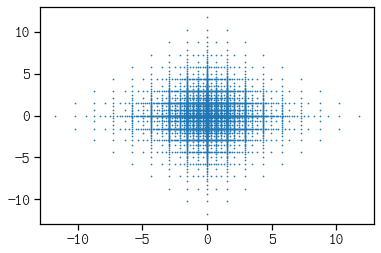

In [12]:
plt.scatter(em_pf.exponential_density.bijected_points[:,0],em_pf.exponential_density.bijected_points[:,1],s=0.5)
# plt.scatter(em_pf.exponential_density.quadrature_points[:,0],em_pf.exponential_density.quadrature_points[:,1],s=1)

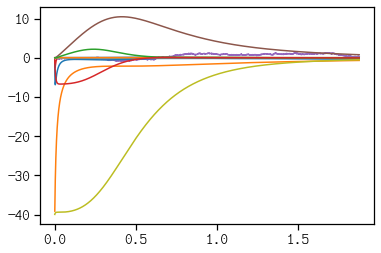

In [13]:
em_pf.propagate()
plt.plot(tspan[1:],em_pf.state_history)

In [14]:
max_limit = 5
num_point = 150
grid_limits = jnp.array([[-max_limit,max_limit],[-max_limit,max_limit]])
num_points = jnp.array([num_point,num_point], dtype=jnp.int32)
dxs = jnp.diff(grid_limits,axis=-1).squeeze()/num_points
bins = num_points
interpolation= 'lanczos'
ranges= grid_limits

In [15]:
grids, pf_density_history = em_pf.get_density_values(grid_limits,num_points)

In [16]:
process_cov = dt*(SIGMA_W**2)*jnp.array([[0.,0.],[0.,1.]])
meas_cov = dt*(SIGMA_V**2)*jnp.eye(1)
dy = jnp.diff(measurement_record,axis=0)
n_devices=jax.local_device_count()
n_particle_per_device= 2500 #1250
prng_key = PRNGKey(3123)

prng_key, subkey = jrandom.split(prng_key)
W_0 = jrandom.normal(subkey,(n_devices,n_particle_per_device,2))
state_init = init_mean+jnp.sqrt(jnp.diag(var_init))*W_0

In [17]:
jnp.prod(dxs)

DeviceArray(0.00444445, dtype=float32)

In [18]:
grids, pf_density_history = em_pf.get_density_values(grid_limits,num_points)
pde_filter = two_d.TwoDNonLinearFilterPDE(one_d_grids=(grids[0, :, 0], grids[0, :, 0]),
                                          dynamic_drift=f_dynamic_cont,
                                          dynamic_diffusion=g_dynamic_cont,
                                          measurement_drift=h_meas_cont,
                                          initial_condition=pf_density_history[0].T,
                                          delta_t=dt,
                                          measurement_record=measurement_record,
                                          measurement_stdev=SIGMA_V)
density_history = pde_filter.propagate_zakai()

In [19]:
particle_filter = par_f.ParticleFilter(n_devices=n_devices,
                                     n_particle_per_device=n_particle_per_device,
                                     state_init=state_init,
                                     measurement_history=dy,
                                     transition_fun=f_dynamic,
                                     output_fun=h_meas,
                                     constraint=None,
                                     process_cov=process_cov,
                                     meas_cov=meas_cov,
                                     prng_key=prng_key)

(neg_log_likelihood_end, state_end, x_particle_history,
 neg_likelihood_history, log_weights_history,
 estimated_state_history) = particle_filter.run()
x_particle_history = x_particle_history.reshape((tspan.shape[0]-1,n_devices*n_particle_per_device,2))

In [20]:
x_particle_history.shape

(7500, 2500, 2)

In [31]:
%store density_history
%store x_particle_history

Stored 'density_history' (DeviceArray)
Stored 'x_particle_history' (DeviceArray)


In [21]:
r = (dt)/(jnp.prod(dxs))
print('To have a stable simulation, usually r needs to be less than 0.5. Here we have r = {:.3f}'.format(r))

To have a stable simulation, usually r needs to be less than 0.5. Here we have r = 0.056


In [22]:
@partial(jnp.vectorize, signature='(n)->()',excluded=[1,2])
def gaussian_kernel_density(point, samples, bandwidth):
    scaled_points = bandwidth@(point-samples).T
    gaussian_kernel = jnp.exp(-0.5 * jnp.sum(jnp.square(scaled_points),axis=0)) / jnp.power(2 * jnp.pi, 0.5*point.shape[0])
    return jnp.sum(gaussian_kernel)/samples.shape[0]  

@jit
def gkd_history(grids, x_particle_history, bandwith):
    @jit 
    def scanned_fun(_carry,_input):
        _samples = _input
        _a_density = gaussian_kernel_density(grids,_samples,bandwith)
        return _carry, _a_density
    _, gkd_history = scan(scanned_fun,[],x_particle_history)
    return gkd_history

# @partial(jnp.vectorize, signature='(n)->()',excluded=[1,2])
# def epanechnikov_kernel_density(point, samples, bandwidth):
#     scaled_points = jnp.maximum(0, (point-samples)/bandwidth)
#     _kernel = 0.75*(1 - jnp.sum(jnp.square(scaled_points),axis=-1))
#     return jnp.sum(_kernel)/samples.shape[0]  

In [23]:
@partial(jnp.vectorize,signature='(n,n),(n,n)->()',excluded=(2,))
def hellinger_distance(den_1,den_2,dxs):
    delta_sqrt_dens = jnp.sqrt(jnp.maximum(den_1,0)) - jnp.sqrt(jnp.maximum(den_2,0))
    return 0.5*jnp.trapz(jnp.trapz(jnp.square(delta_sqrt_dens), dx=dxs[0], axis=0), dx=dxs[1])

In [26]:
particle_kde_density_history = []
thinning = 4
kde_bandwidth_multiplier = 30
Sigma_inverse = jnp.linalg.solve(jnp.eye(2),jnp.cov(x_particle_history[0].T))
kde_bandwidth = kde_bandwidth_multiplier*jnp.linalg.cholesky(Sigma_inverse)
# for time_index in tqdm(range(density_history.shape[0])):
#     particle_kde_density_history.append(gaussian_kernel_density(grids,x_particle_history[time_index,::thinning,:],kde_bandwidth))
particle_kde_density_history = gkd_history(grids,x_particle_history[:,::thinning,:],kde_bandwidth)

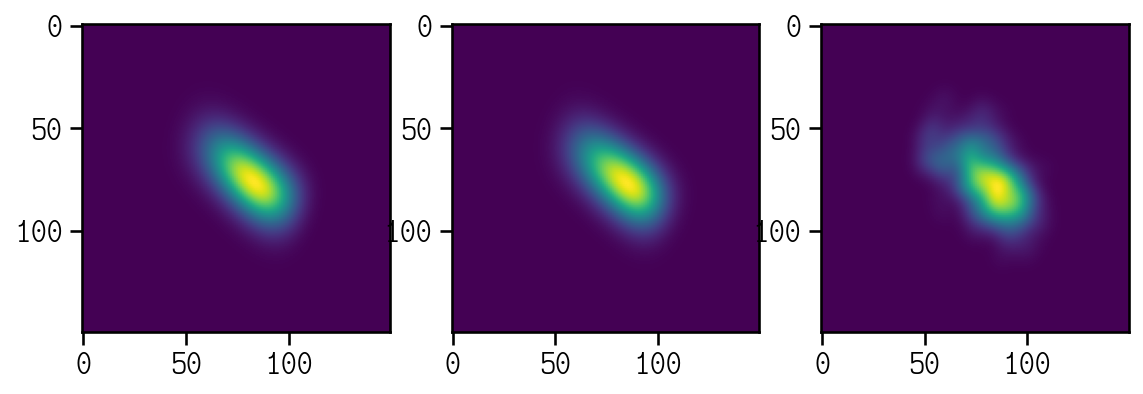

In [27]:
fig, axs=plt.subplots(1,3,dpi=150,figsize=(9,3))
time_index=7000
axs[0].imshow(density_history[time_index].T)
axs[1].imshow(pf_density_history[time_index])
axs[2].imshow(particle_kde_density_history[time_index])

In [32]:
hell_dists = hellinger_distance(jnp.transpose(density_history,axes=(0,2,1)),pf_density_history,dxs)
hell_dists_par = hellinger_distance(jnp.transpose(density_history,axes=(0,2,1)),particle_kde_density_history,dxs)

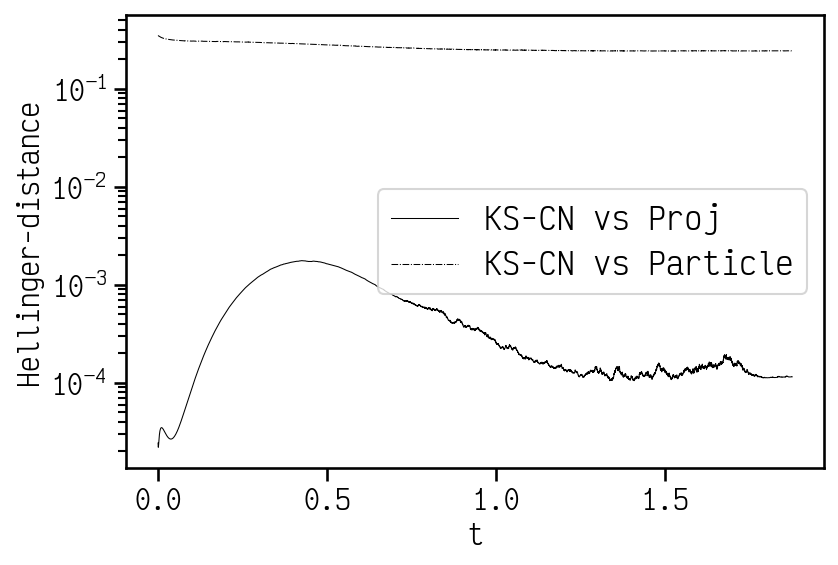

In [34]:
plt.figure(dpi=150)
index_end=nt
plt.semilogy(tspan[1:index_end+1],hell_dists[:index_end],linewidth=0.5,color='black',label='KS-CN vs Proj')
plt.semilogy(tspan[1:index_end+1],hell_dists_par[:index_end],'-.k',linewidth=0.5,label='KS-CN vs Particle')
plt.xlabel('t')
plt.legend()
plt.ylabel('Hellinger-distance')
plt.savefig('plots/Zakai_CN_Brigo_Particle_Comparison/Hellinger_vdp_two_d.pdf')

In [40]:
def set_colorbar(ax,im,fg_color):
    cbaxes = inset_axes(ax, width="40%", height="3%", loc=1) 
    cb = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
    cb.outline.set_edgecolor(fg_color)
    cb.ax.xaxis.set_tick_params(color=fg_color)
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color=fg_color)
    cb.ax.axes.get_xticklabels()
    plt.setp(cb.ax.axes.get_xticklabels(), fontsize=6)

In [41]:
@partial(onp.vectorize,signature='(n),(n)->(m,m)')
def histogram2d(particle_x,particle_y):
    density,_,_= onp.histogram2d(particle_x,particle_y,range=ranges,bins=bins,density=True)
    return density

In [27]:
# f, ax = plt.subplots(1,4,dpi=150)
# time_index= (nt*50)//100
# density_hist = histogram2d(x_particle_history[time_index,:,0],x_particle_history[time_index,:,1])
# density_kde = gaussian_kernel_density(grids,x_particle_history[time_index,::5*thinning,:],2e-1)
# ax[0].imshow(pf_density_history[time_index],extent=[-max_limit,max_limit,-max_limit,max_limit])
# ax[1].imshow(density_kde,extent=[-max_limit,max_limit,-max_limit,max_limit])
# ax[2].imshow(density_hist.T,extent=[-max_limit,max_limit,-max_limit,max_limit])
# ax[3].imshow(density_history[time_index].T,extent=[-max_limit,max_limit,-max_limit,max_limit])

In [28]:
# density_hist = histogram2d(x_particle_history[:,:,0],x_particle_history[:,:,1])

In [29]:
moments_projection_filter = em_pf.exponential_density.natural_statistics_expectation(em_pf.state_history)

In [30]:
moment_grids = em_pf.exponential_density.natural_statistics(pde_filter.grids)
moment_grids = jnp.swapaxes(jnp.swapaxes(moment_grids,2,0),1,2)
@partial(jnp.vectorize,signature='(n,n)->(m)')
def compute_zakai_moment(a_density):
    moments = jnp.trapz(jnp.trapz(a_density*moment_grids,dx=dxs[1],axis=2),dx=dxs[0],axis=1)
    return moments

In [31]:
moments_zakai_filter = onp.zeros((density_history.shape[0],moment_grids.shape[0]))
for i_ in range(density_history.shape[0]):
#     density_ /= jnp.trapz(jnp.trapz(density_history[i_],dx=dxs[1],axis=1),dx=dxs[0],axis=0)
    moments_zakai_filter[i_] =  compute_zakai_moment(density_history[i_])

In [32]:
sums = em_pf.exponential_density.natural_statistics(x_particle_history)

In [33]:
moments_particle_filter = jnp.mean(sums,axis=1)

In [34]:
skip = 100
density_history = density_history[::skip] # reduce memory print
pf_density_history = pf_density_history[::skip]
x_particle_history = x_particle_history[::skip]

In [56]:
use_kde = True
# thinning = 4
# kde_bandwidth_multiplier = 30
for time_index in jnp.arange(0,pf_density_history.shape[0]):
    fig, axs=plt.subplots(1,3,dpi=150,figsize=(9,3))
    fg_color = fg_color = 'black'
    cmap = plt.cm.Blues
    density_zakai = density_history[time_index].T    
    density_zakai /= jnp.trapz(jnp.trapz(density_zakai,dx=dxs[1],axis=1),dx=dx[0],axis=0)
    
    max_density_zakai = jnp.max(jnp.abs(density_zakai))
    
    density_pf = pf_density_history[time_index]
    density_pf /= jnp.trapz(jnp.trapz(density_pf,dx=dxs[1],axis=1),dx=dx[0],axis=0)
    max_density_pf = max_density = jnp.max(jnp.abs(density_pf))
    
    Sigma_inverse = jnp.linalg.solve(jnp.eye(2),jnp.cov(x_particle_history[0].T))
    kde_bandwidth = kde_bandwidth_multiplier*jnp.linalg.cholesky(Sigma_inverse)
    
    if use_kde:
#         density_par_f = gaussian_kernel_density(grids,x_particle_history[time_index,::thinning,:],kde_bandwidth)
        density_par_f = 
    else:
        density_par_f = histogram2d(x_particle_history[time_index,:,0],x_particle_history[time_index,:,1]).T
    density_par_f /= jnp.trapz(jnp.trapz(density_par_f,dx=dxs[1],axis=1),dx=dx[0],axis=0)
    max_density_par_f = jnp.max(jnp.abs(density_par_f))
    
    max_density = jnp.max(jnp.array([max_density_zakai,max_density_par_f,max_density_pf]))
    im0 = axs[0].imshow(density_zakai,cmap=cmap,vmin=0,vmax=max_density,extent=grid_limits.ravel(), 
                   origin='lower',
                   alpha=1,
                  interpolation=interpolation)
    set_colorbar(axs[0],im0,fg_color)
    axs[0].set_title('Crank-Nicolson Solution t={:.3f}'.format(time_index*skip*dt),loc='center')
    
    
    im1 = axs[1].imshow(density_pf,cmap=cmap,vmin=0,vmax=max_density,extent=grid_limits.ravel(), 
                   origin='lower',
                   alpha=1,
                  interpolation=interpolation)
    set_colorbar(axs[1],im1,fg_color)
    axs[1].set_title('Projection Density t={:.3f}'.format(time_index*skip*dt),loc='center')
    
    
    im2 = axs[2].imshow(density_par_f,cmap=cmap,vmin=0,vmax=max_density,extent=grid_limits.ravel(), 
                   origin='lower',
                   alpha=1,
                  interpolation=interpolation)
    set_colorbar(axs[2],im2,fg_color)
    axs[2].set_title('Particle Density t={:.3f}'.format(time_index*skip*dt),loc='center')
    
#     difference = density_pf-density_zakai
#     difference_par = density_par_f-density_zakai
# #     max_difference = #max(max_density,max_density_pf)
#     max_difference_brigo = max(jnp.abs(jnp.min(difference)),jnp.abs(jnp.max(difference)))
#     max_difference_par   = max(jnp.abs(jnp.min(difference_par)),jnp.abs(jnp.max(difference_par)))
#     max_difference = max(max_difference_brigo,max_difference_par)
#     im3 = axs[3].imshow(difference,cmap=plt.cm.seismic_r,vmin=-max_difference,vmax=max_difference,extent=grid_limits.ravel(), 
#                    origin='lower',
#                    alpha=1,
#                   interpolation=interpolation)
#     set_colorbar(axs[3],im3,fg_color)
#     axs[3].set_title('Brigo-Zakai t={:.3f}'.format(time_index*skip*dt),loc='center')
#     plt.tight_layout()

#     im4 = axs[4].imshow(difference_par,cmap=plt.cm.seismic_r,vmin=-max_difference,vmax=max_difference,extent=grid_limits.ravel(), 
#                    origin='lower',
#                    alpha=1,
#                   interpolation=interpolation)
#     set_colorbar(axs[4],im4,fg_color)
#     axs[4].set_title('Particle-Zakai t={:.3f}'.format(time_index*skip*dt),loc='center')
    plt.tight_layout()
    plt.savefig('plots/Zakai_CN_Brigo_Particle_Comparison/plot_t_{:.3f}_nodes_number_{}.pdf'.format(time_index*skip*dt,em_pf.exponential_density.nodes_number))
    plt.close()

<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-56-5f589eb07a5c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 

In [36]:
statistics_str = [str(stat).replace('**', '^').replace(
        'x1', 'x_1').replace('x2', 'x_2').replace('*', '') for stat in natural_statistics_symbolic]

In [38]:
for natural_statistics_index in range(natural_statistics_symbolic.shape[0]):
    plt.figure(dpi=150)
    index_end=nt
    plt.plot(tspan[1:index_end+1],moments_projection_filter[:index_end,natural_statistics_index],color='blue',label='Projection',linewidth=0.5)
    plt.plot(tspan[1:index_end+1],moments_particle_filter[:index_end,natural_statistics_index],color='black',label='Particle',linewidth=0.5)
    plt.plot(tspan[1:index_end+1],moments_zakai_filter[:index_end,natural_statistics_index],color='red',label='Crank-Nicolson',linewidth=0.5)
    plt.legend()
    plt.xlabel('t')
    plt.title('$E[{}]$'.format(statistics_str[natural_statistics_index]),loc='center')
    plt.tight_layout()
    plt.savefig('plots/Zakai_CN_Brigo_Particle_Comparison/Moment_comparison_{}.pdf'.format(natural_statistics_index+1))
    plt.close()
    plt.figure(dpi=150)
    plt.semilogy(tspan[1:index_end+1],jnp.abs(moments_projection_filter[:index_end,natural_statistics_index]-moments_zakai_filter[:index_end,natural_statistics_index])
             ,color='blue',label='$|E_a[{}]-E_b[{}]|$'.format(statistics_str[natural_statistics_index],statistics_str[natural_statistics_index]),linewidth=0.5)
    plt.semilogy(tspan[1:index_end+1],jnp.abs(moments_particle_filter[:index_end,natural_statistics_index]-moments_zakai_filter[:index_end,natural_statistics_index])
             ,color='black',label='$|E_a[{}]-E_c[{}]|$'.format(statistics_str[natural_statistics_index],statistics_str[natural_statistics_index]),linewidth=0.5)
    plt.legend()
    plt.xlabel('t')
#     plt.title('Absolute value in the difference of $E[{}]$,'.format(statistics_str[natural_statistics_index],statistics_str[natural_statistics_index]),loc='center')
    plt.tight_layout()
    plt.savefig('plots/Zakai_CN_Brigo_Particle_Comparison/Moment_Errors_{}.pdf'.format(natural_statistics_index+1))
    plt.close()

In [37]:
x_particle_history.shape

(30, 2500, 2)